In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flood-area-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2738852%2F4732950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T121432Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8f198c8380ac62a530d314b49157d98240fd3fa7ef81a319deb268b658034cc47cff4e890442a77a3a8239ee49466c8ad85c62470a0ba3cbe95b403d9a3e799acb7663900f5f93bc0bcf6c48b60b4171ebcaf3db9c5c5ae7a9a4ecce54e0d99c2eb5f422fae1f18564aff9579e8e36aaa7ad60e67ad9283824076b63f899ab2ee9aa341342e2b6020b582ed6c2b1e0a1c3e6369e8a4f1970ceaa22e3db50b44ecd867f2d1e94aed6ae05be00bb184c506e874d7408061e62d859f4563bb8a8e8cf779f12d6e093c3d8a09505d4f51c33f7f7fd32f9a3a35b10bb8d18001d6ee2bf59020a0ae9d76edc2c23f673175371bc3b2dee1176ef8eb965210fdbab0b48'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112072442 bytes downloaded
Downloaded and uncompressed: flood-area-segmentation
Data source import complete.


In [ ]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K

np.__version__

'1.25.2'

In [ ]:
!pip install segmentation_models
!pip install  -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
  Attempting uninstall: albumentations
    Found existing installation: albumen

In [ ]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
PATH = '/kaggle/input/flood-area-segmentation/'

df = pd.read_csv(PATH + 'metadata.csv')
df.head()

Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

In [ ]:
import segmentation_models as sm
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 3, p = 0.5),
    # A.RandomRotate90(p=1) ,
    # A.Rotate(limit=90,p=0.5) ,
    # A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

])

Segmentation Models: using `tf.keras` framework.


In [ ]:
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)


In [ ]:
df

['/kaggle/input/flood-area-segmentation/Image/3095.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3095.png']


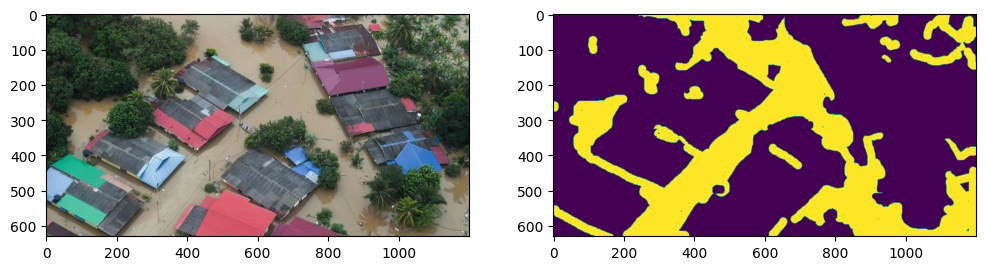

['/kaggle/input/flood-area-segmentation/Image/1027.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/1027.png']


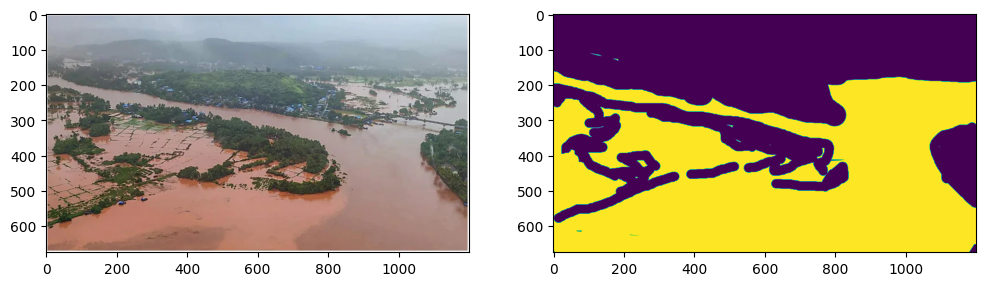

['/kaggle/input/flood-area-segmentation/Image/3018.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3018.png']


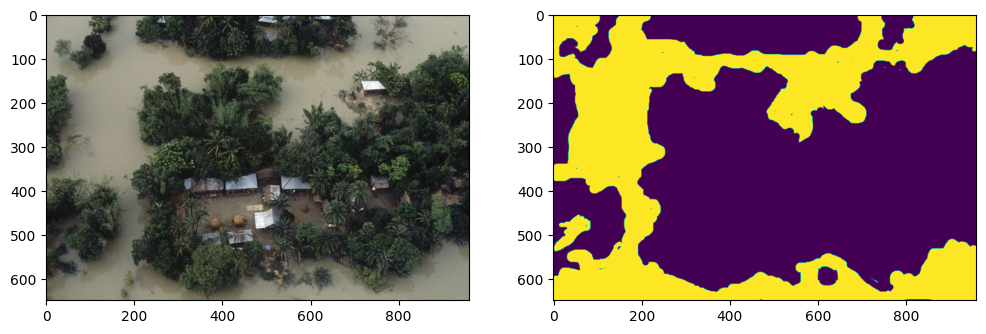

['/kaggle/input/flood-area-segmentation/Image/3087.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3087.png']


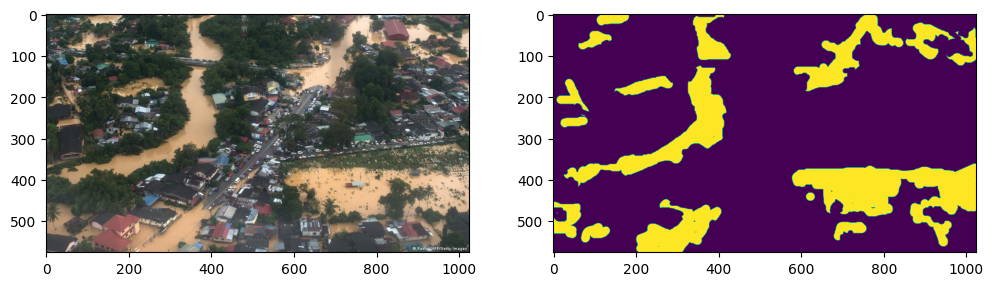

['/kaggle/input/flood-area-segmentation/Image/3084.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3084.png']


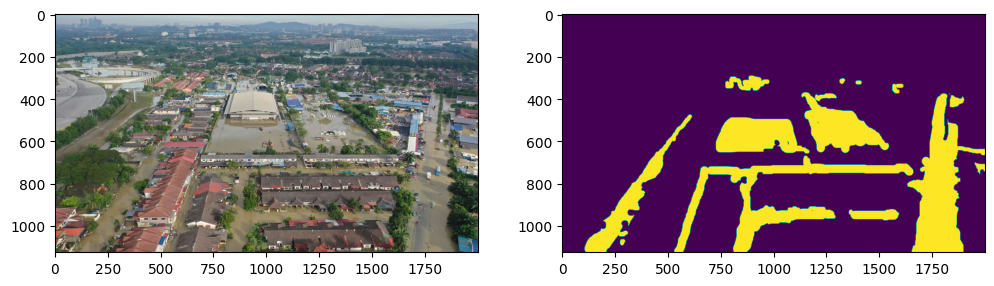

In [ ]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)
    mask = plt.imread(sample.iloc[0, 1], 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

In [ ]:
IMG_SIZE = (224, 224)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask

def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))

    img = img/255.0
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [ ]:
BATCH_SIZE = 16

def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.1)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)


(261, 2) (29, 2)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
model = sm.Unet('efficientnetb2',
                input_shape = (224,224,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
# model.summary()

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-4),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

In [ ]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 15)

Epoch 1/15
17/17 [==============================] - 320s 16s/step - loss: 0.6211 - iou_score: 0.4065 - val_loss: 0.7614 - val_iou_score: 0.2447
Epoch 2/15
17/17 [==============================] - 271s 16s/step - loss: 0.4033 - iou_score: 0.5213 - val_loss: 0.6048 - val_iou_score: 0.3384
Epoch 3/15
17/17 [==============================] - 272s 16s/step - loss: 0.3289 - iou_score: 0.5836 - val_loss: 0.5018 - val_iou_score: 0.4255
Epoch 4/15
17/17 [==============================] - 266s 16s/step - loss: 0.2833 - iou_score: 0.6350 - val_loss: 0.4338 - val_iou_score: 0.5229
Epoch 5/15
17/17 [==============================] - 264s 15s/step - loss: 0.2591 - iou_score: 0.6527 - val_loss: 0.4411 - val_iou_score: 0.5633
Epoch 6/15
17/17 [==============================] - 266s 16s/step - loss: 0.2370 - iou_score: 0.6768 - val_loss: 0.3817 - val_iou_score: 0.6136
Epoch 7/15
17/17 [==============================] - 264s 15s/step - loss: 0.2258 - iou_score: 0.6975 - val_loss: 0.3705 - val_iou_score:

<ipython-input-16-5627971b1f19>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


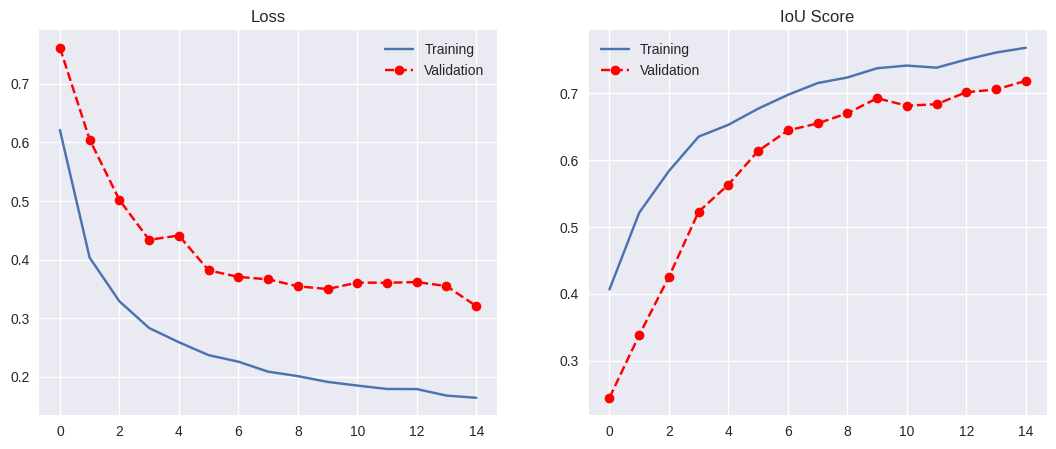

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()


In [ ]:
color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(-0.5, 223.5, 223.5, -0.5)

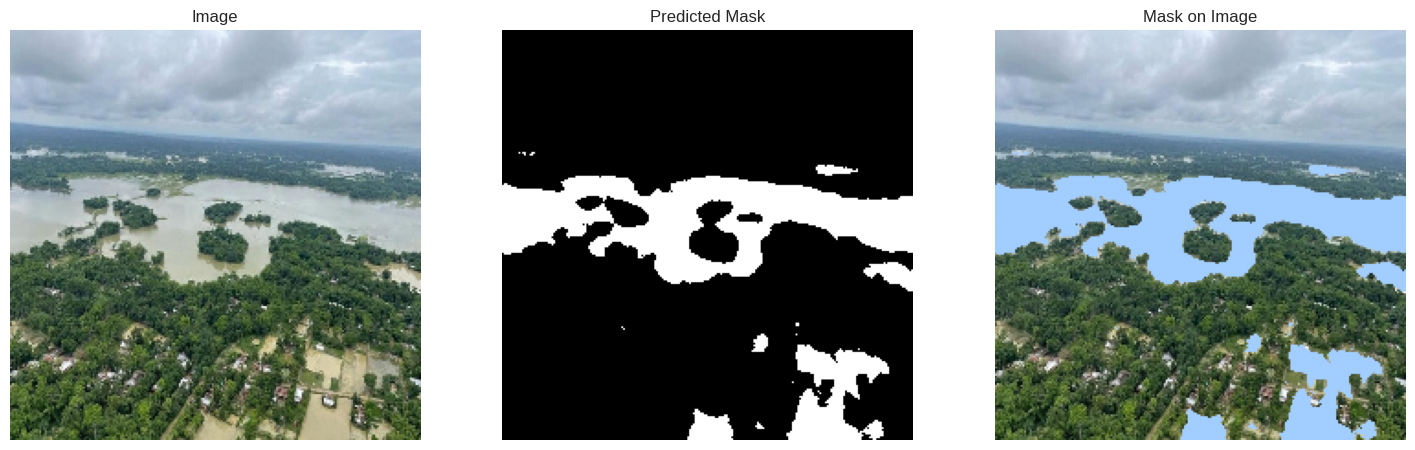

In [ ]:
url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))

(-0.5, 223.5, 223.5, -0.5)

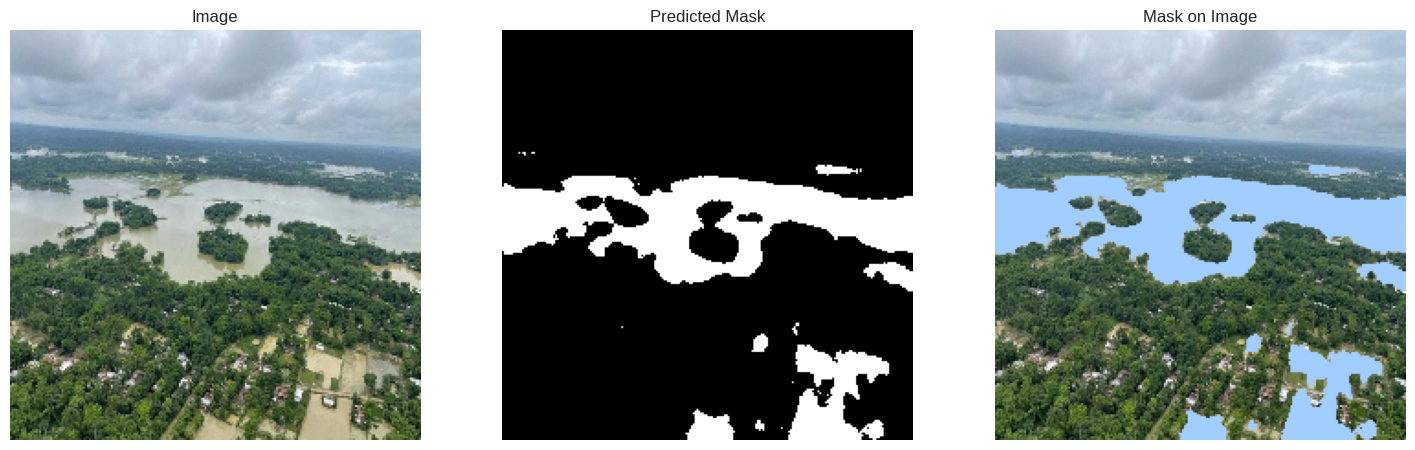

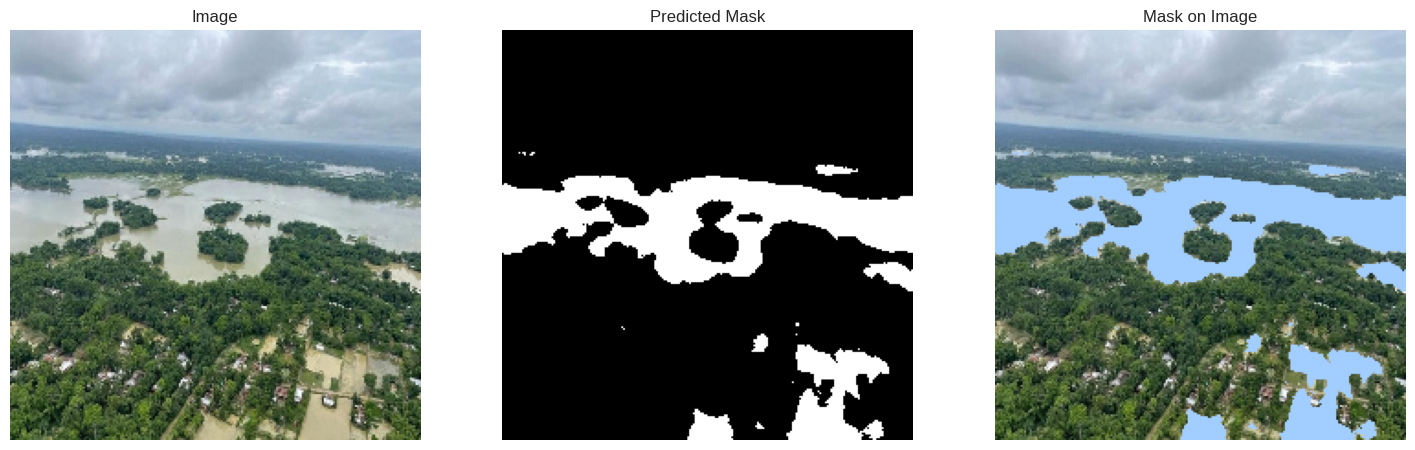

In [ ]:
url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))